In [1]:
import numpy as np
import pandas as pd
import matplotlib 
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, roc_curve, auc, plot_confusion_matrix, RocCurveDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.ensemble import GradientBoostingClassifier

from preprocessing import *

plt.rcParams["figure.dpi"] = 60

# Carga del dataset

In [2]:
from collections import Counter
import requests

with requests.get(
    "https://docs.google.com/spreadsheets/d/1wduqo5WyYmCpaGnE81sLNGU0VSodIekMfpmEwU0fGqs/export?format=csv") as r, open("features.csv", "wb") as f:
    for chunk in r.iter_content():
        f.write(chunk)

with requests.get(
    "https://docs.google.com/spreadsheets/d/1gvZ03uAL6THwd04Y98GtIj6SeAHiKyQY5UisuuyFSUs/export?format=csv") as r, open("target.csv", "wb") as f:
    for chunk in r.iter_content():
        f.write(chunk)

In [3]:
df_features = pd.read_csv("features.csv")
df_target = pd.read_csv("target.csv")
df = df_features.merge(df_target, left_on='id', right_on='id')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Seleccion de modelos

Buscamos la mejor combinación de los hiperparámetros n_estimators, learning_rate y max_depth, con 2 datasets distintos, utilizando Randomized Search.

In [4]:
X_train, X_test, y_train, y_test = preprocessing_arboles_1(df)
params = {
    'n_estimators': np.arange(50, 150),
    'learning_rate': np.arange(0.1, 0.5, 0.1),
    'max_depth': np.arange(1, 3),
}

clf = GradientBoostingClassifier(random_state=0)

rgscv = RandomizedSearchCV(
    clf, params, n_iter = 10, scoring='roc_auc', n_jobs=-1, cv=3, return_train_score=True
).fit(X_train, y_train)

print(f"Best score: {rgscv.best_score_}")
print(f"Best params {rgscv.best_params_}")

Best score: 0.8812081970796056
Best params {'n_estimators': 120, 'max_depth': 2, 'learning_rate': 0.4}


In [5]:
X_train, X_test, y_train, y_test = preprocessing_arboles_2(df)
params = {
    'n_estimators': np.arange(50, 150),
    'learning_rate': np.arange(0.1, 0.5, 0.1),
    'max_depth': np.arange(1, 3),
}

clf = GradientBoostingClassifier(random_state=0)


rgscv = RandomizedSearchCV(
    clf, params,  n_iter = 10, scoring='roc_auc', n_jobs=-1, cv=3, return_train_score=True
).fit(X_train, y_train)

print(f"Best score: {rgscv.best_score_}")
print(f"Best params {rgscv.best_params_}")

Best score: 0.8755485921962533
Best params {'n_estimators': 148, 'max_depth': 2, 'learning_rate': 0.4}


# Evaluación del modelo final

El mejor modelo encontrado corresponde al preprocesamiento 
Entrenamos el modelo y evaluamos utilizando el set de holdout.

In [6]:
X_train, X_test, y_train, y_test = preprocessing_arboles_2(df)

clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:,1]

In [7]:
print(f"Auc Roc: {roc_auc_score(y_test, y_pred_proba)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1 Score: {f1_score(y_test, y_pred)}")

Auc Roc: 0.8741417471311198
Accuracy: 0.8479942435689872
Precision: 0.7248084855627578
Recall: 0.5014268242967794
F1 Score: 0.5927710843373495


## Matriz de confusion

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


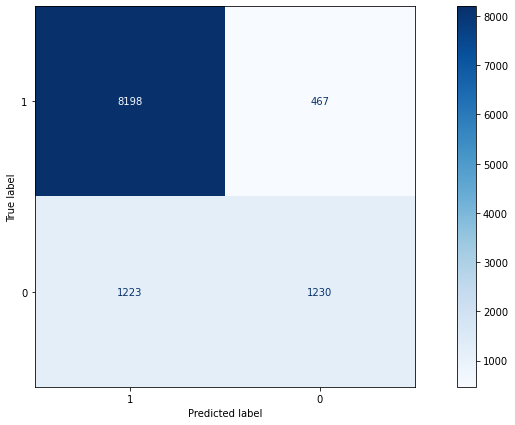

In [8]:
fig, ax = plt.subplots(figsize=(15, 7))
plt.grid(False)
plot_confusion_matrix(
    clf, X_test, y_test, cmap=plt.cm.Blues, display_labels=['1', '0'], ax=ax
)
plt.show()

## Curva ROC

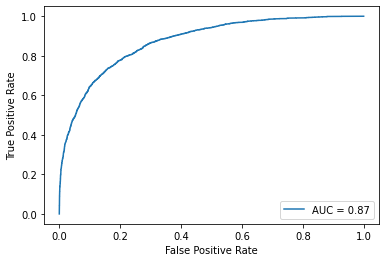

In [9]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()
plt.show()

# Predicciones finales

In [10]:
X_train, X_test, y_train, y_test = preprocessing_arboles_2(df)

clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)

with requests.get(
    "https://docs.google.com/spreadsheets/d/1mR_JNN0-ceiB5qV42Ff9hznz0HtWaoPF3B9zNGoNPY8/export?format=csv") as r, open("pred.csv", "wb") as f:
    for chunk in r.iter_content():
        f.write(chunk)

df_pred = pd.read_csv("pred.csv")

df_pred_preprocess = preprocessing_boosting_pred(df_pred)
y_pred_final = clf.predict(df_pred_preprocess)
df_pred_final = pd.DataFrame({'id': df_pred['id'], 'llovieron_hamburguesas_al_dia_siguiente': y_pred_final})
df_pred_final.loc[df_pred_final['llovieron_hamburguesas_al_dia_siguiente'] == 1, 'llovieron_hamburguesas_al_dia_siguiente'] = 'si'
df_pred_final.loc[df_pred_final['llovieron_hamburguesas_al_dia_siguiente'] == 0, 'llovieron_hamburguesas_al_dia_siguiente'] = 'no'

df_pred_final

NameError: ignored

In [ ]:
df_pred_final.to_csv('predicciones/boosting.csv', index=False)